In [1]:
import torch
import torchvision
import random
from PIL import Image
from torch import nn
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import os
from pathlib import Path
import shutil
from torchvision import datasets
from torch.utils.data import DataLoader
import ssl
import torcheval
from torcheval.metrics import BinaryAccuracy
from tqdm.auto import tqdm


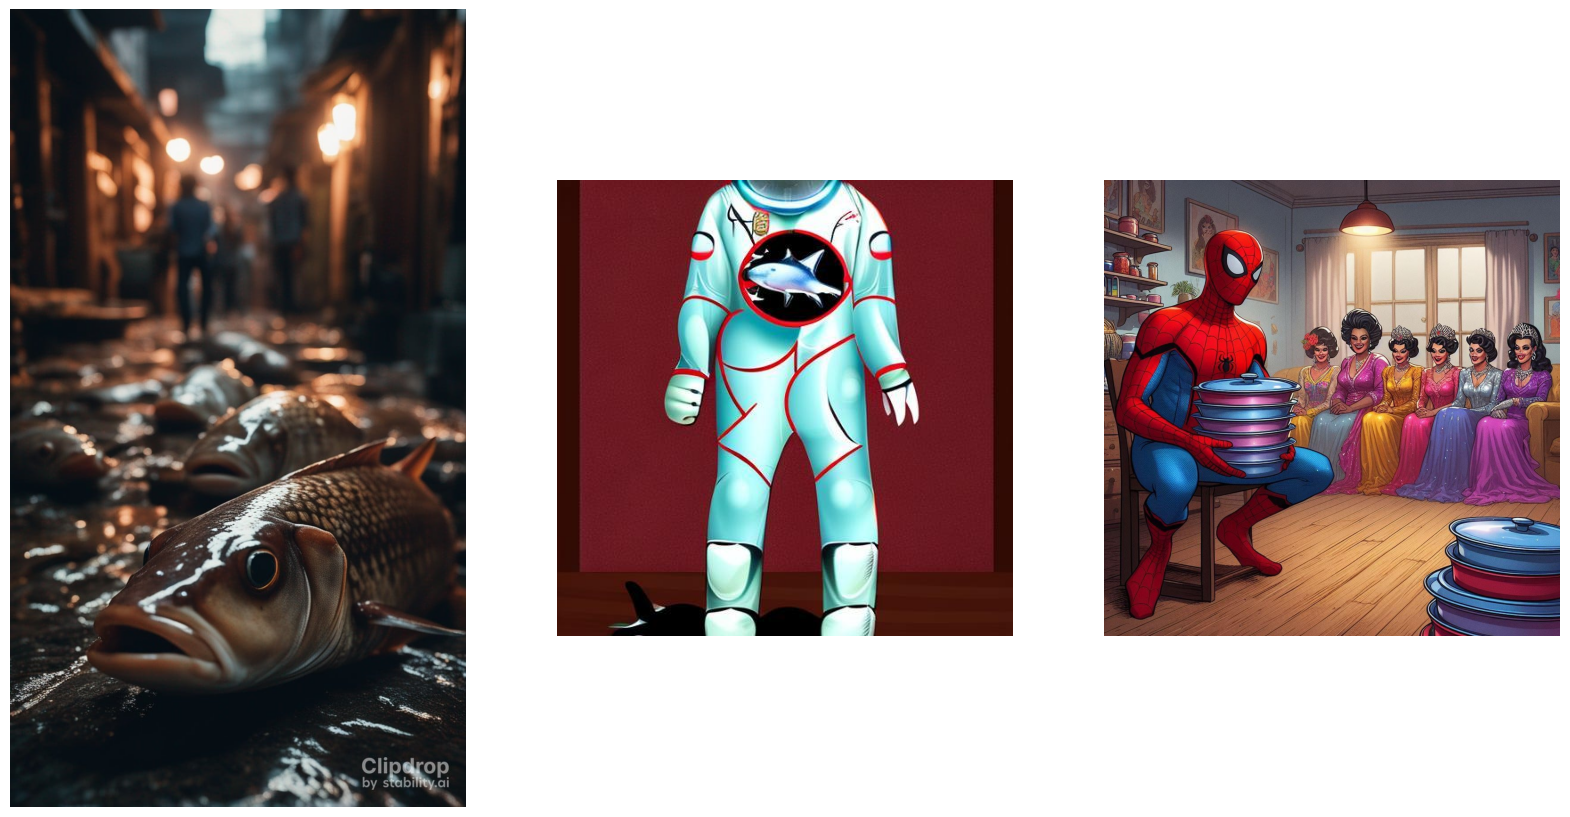

In [4]:
data_path = Path("archive")
ai_dir = data_path / "AiArtData" / "AiArtData"
real_dir = data_path / "RealArt" / "RealArt" 
ai_image_path_list = list(Path(ai_dir).glob("*.jpg"))
random_ai_image = random.sample(ai_image_path_list, k=3)
plt.figure(figsize=(20, 15))

i = 1
for image_path in random_ai_image:
    plt.subplot(1, 3, i)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis(False)
    i += 1

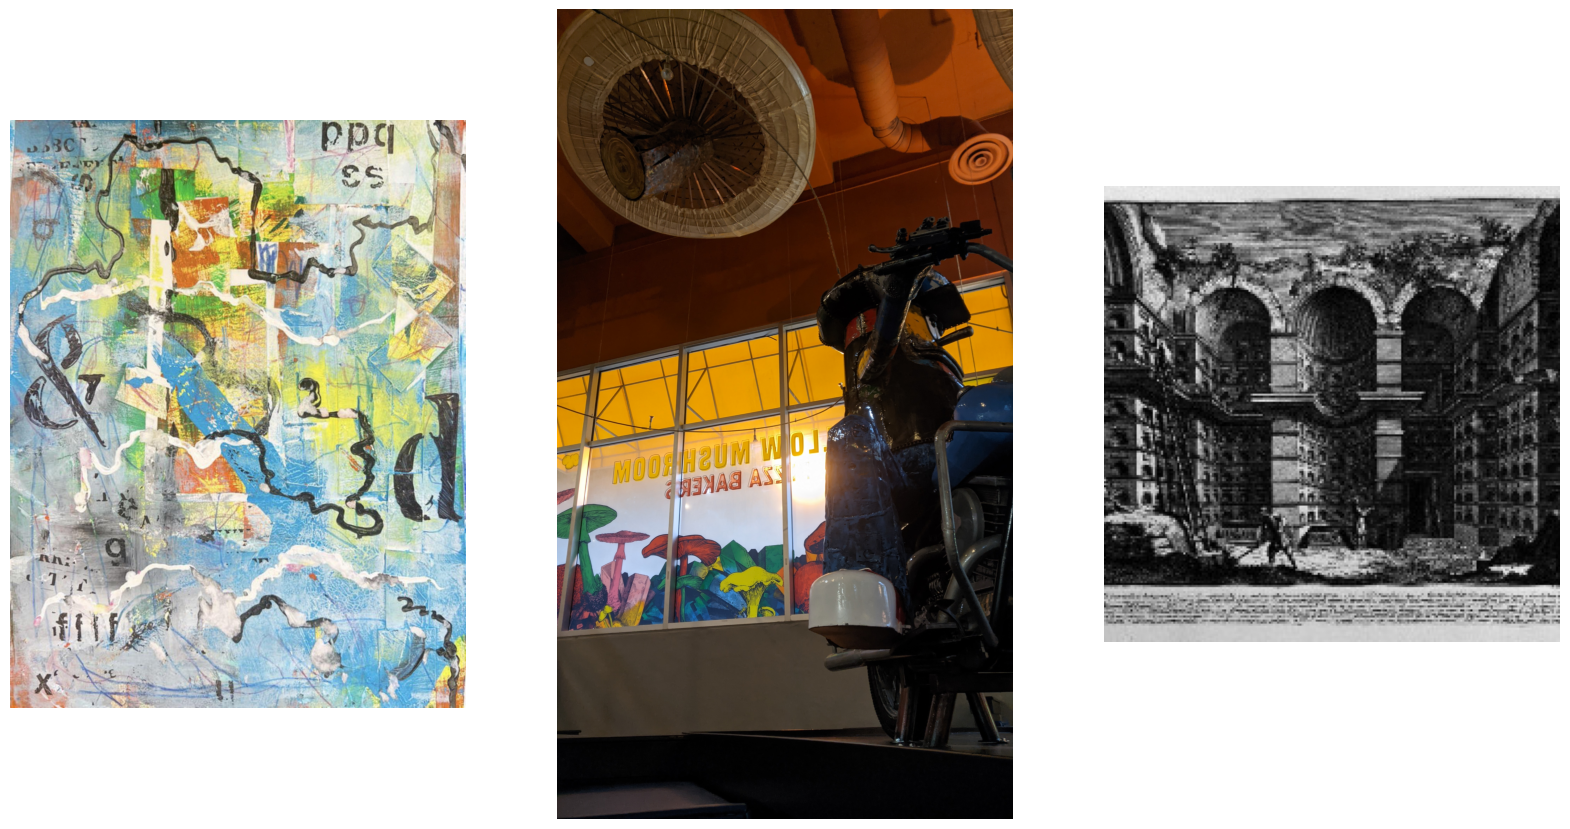

In [5]:
real_image_path_list = list(Path(real_dir).glob("*.jpg"))
random_real_image = random.sample(real_image_path_list, k=3)
plt.figure(figsize=(20, 15))

i = 1
for image_path in random_real_image:
    plt.subplot(1, 3, i)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis(False)
    i += 1

In [6]:
new_data_path = Path("/working/data")
new_data_path.mkdir(parents=True, exist_ok=True)

train_path = new_data_path / "train"
test_path = new_data_path / "test"

os.mkdir(train_path)
os.mkdir(test_path)

train_ai_split = int(len(ai_image_path_list) * 0.8)
train_real_split = int(len(real_image_path_list) * 0.8)

train_ai_img = random.sample(ai_image_path_list, k=train_ai_split)
train_real_img = random.sample(real_image_path_list, k=train_real_split)

test_ai_img = []
test_real_img = []

for ai_img in ai_image_path_list:
    if ai_img not in train_ai_img:
        test_ai_img.append(ai_img)
    
for real_img in real_image_path_list:
    if real_img not in train_real_img:
        test_real_img.append(real_img)
print(f"ai_image_path_list: {len(ai_image_path_list)}")
print(f"real_image_path_list: {len(real_image_path_list)}")
print(f"train_ai_img: {len(train_ai_img)}")
print(f"train_real_img: {len(train_real_img)}")
print(f"test_ai_img: {len(test_ai_img)}")
print(f"test_real_img: {len(test_real_img)}")

ai_image_path_list: 2116
real_image_path_list: 3951
train_ai_img: 1692
train_real_img: 3160
test_ai_img: 424
test_real_img: 791


In [7]:
train_ai_path = train_path / "AiArt"
train_real_path = train_path / "RealArt"
test_ai_path = test_path / "AiArt"
test_real_path = test_path / "RealArt"

os.mkdir(train_ai_path)
os.mkdir(train_real_path)
os.mkdir(test_ai_path)
os.mkdir(test_real_path)

for img in train_ai_img:
    shutil.copy(img, train_ai_path)
for img in train_real_img:
    shutil.copy(img, train_real_path)
for img in test_ai_img:
    shutil.copy(img, test_ai_path)
for img in test_real_img:
    shutil.copy(img, test_real_path)

In [10]:
weights = torchvision.models.ResNet152_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
train_data = datasets.ImageFolder(root=train_path,
                                 transform=auto_transforms)
test_data = datasets.ImageFolder(root=test_path,
                                transform=auto_transforms)
class_names = train_data.classes
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
class_names

Train data:
Dataset ImageFolder
    Number of datapoints: 4852
    Root location: kaggle/working/data/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1215
    Root location: kaggle/working/data/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [14]:
# ssl._create_default_https_context = ssl._create_unverified_context
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
num_workers = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=32,
                             num_workers=num_workers,
                             shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=num_workers,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17fd99550>,
 <torch.utils.data.dataloader.DataLoader at 0x17fba9c50>)

In [15]:
# model = torchvision.models.resnet152(weights="IMAGENET1K_V2").to(device)
device="mps"
model = torchvision.models.resnet152(weights="IMAGENET1K_V2").to(device)
print(next(model.parameters()).dtype)


torch.float32


In [16]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

In [17]:
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = False

In [18]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [19]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [20]:
model.fc = nn.Sequential(
nn.Dropout(p=0.5),   
nn.Linear(in_features=2048, out_features=1024, bias=True),
nn.Dropout(p=0.5),
nn.Linear(in_features=1024, out_features=1, bias=True),
)

In [21]:
model.fc

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1, bias=True)
)

In [22]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    metric = BinaryAccuracy(threshold=0.5)
    metric.update(y_pred, y_true)
    return metric.compute().item()

In [25]:
accuracy_fn(torch.tensor([0, 0, 0, 1]), torch.Tensor([0.2, 0.9, 0.9, 0.9]))

0.5

In [28]:

model.to(device)
img, label = next(iter(train_dataloader))
img = img.to(device)
print(img.dtype)
model(img)# i=img
pred = model(img)

print(pred.squeeze())
print(torch.sigmoid(pred.squeeze()))
pred.squeeze().shape, label.shape



torch.float32
tensor([ 0.1824,  0.0531,  0.1511,  0.1229, -0.1000,  0.0187,  0.0838,  0.3641,
         0.2154, -0.0110, -0.0166,  0.2611,  0.2633,  0.1221,  0.3754,  0.1867,
         0.0680,  0.0067,  0.0846,  0.0179, -0.0008,  0.1829,  0.1371,  0.1077,
        -0.0200,  0.1203,  0.1505,  0.0399,  0.0950,  0.0046,  0.2605,  0.0655],
       device='mps:0', grad_fn=<SqueezeBackward0>)
tensor([0.5455, 0.5133, 0.5377, 0.5307, 0.4750, 0.5047, 0.5209, 0.5900, 0.5536,
        0.4972, 0.4959, 0.5649, 0.5655, 0.5305, 0.5928, 0.5465, 0.5170, 0.5017,
        0.5211, 0.5045, 0.4998, 0.5456, 0.5342, 0.5269, 0.4950, 0.5300, 0.5375,
        0.5100, 0.5237, 0.5012, 0.5648, 0.5164], device='mps:0',
       grad_fn=<SigmoidBackward0>)


(torch.Size([32]), torch.Size([32]))

In [29]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn):
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X).squeeze()
        
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy_fn(y_true=y, y_pred=torch.sigmoid(y_pred))
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    
    model.eval()
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            test_pred_logits = model(X).squeeze()
            
            loss = loss_fn(test_pred_logits, y.float())
            test_loss += loss.item()
            
            test_acc += accuracy_fn(y_true=y, y_pred=torch.sigmoid(test_pred_logits))
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [30]:
def train(model: torch.nn.Module,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         accuracy_fn,
         epochs: int = 5):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          accuracy_fn=accuracy_fn)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [31]:
torch.manual_seed(42)
print("done")
torch.mps.manual_seed(42)
print("done")

from timeit import default_timer as timer


start_time = timer()
results = train(model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               epochs=15)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


done
done


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4391 | train_acc: 0.8003 | test_loss: 0.3568 | test_acc: 0.8492
Epoch: 2 | train_loss: 0.3748 | train_acc: 0.8308 | test_loss: 0.3173 | test_acc: 0.8765
Epoch: 3 | train_loss: 0.3673 | train_acc: 0.8392 | test_loss: 0.3238 | test_acc: 0.8698
Epoch: 4 | train_loss: 0.3501 | train_acc: 0.8474 | test_loss: 0.3144 | test_acc: 0.8626
Epoch: 5 | train_loss: 0.3367 | train_acc: 0.8602 | test_loss: 0.3393 | test_acc: 0.8698
Epoch: 6 | train_loss: 0.3491 | train_acc: 0.8454 | test_loss: 0.3157 | test_acc: 0.8674
Epoch: 7 | train_loss: 0.3319 | train_acc: 0.8637 | test_loss: 0.3463 | test_acc: 0.8509
Epoch: 8 | train_loss: 0.3439 | train_acc: 0.8503 | test_loss: 0.3101 | test_acc: 0.8782
Epoch: 9 | train_loss: 0.3412 | train_acc: 0.8502 | test_loss: 0.3549 | test_acc: 0.8533
Epoch: 10 | train_loss: 0.3466 | train_acc: 0.8519 | test_loss: 0.3081 | test_acc: 0.8691
Epoch: 11 | train_loss: 0.3329 | train_acc: 0.8622 | test_loss: 0.3110 | test_acc: 0.8658
Epoch: 12 | train_l

In [32]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

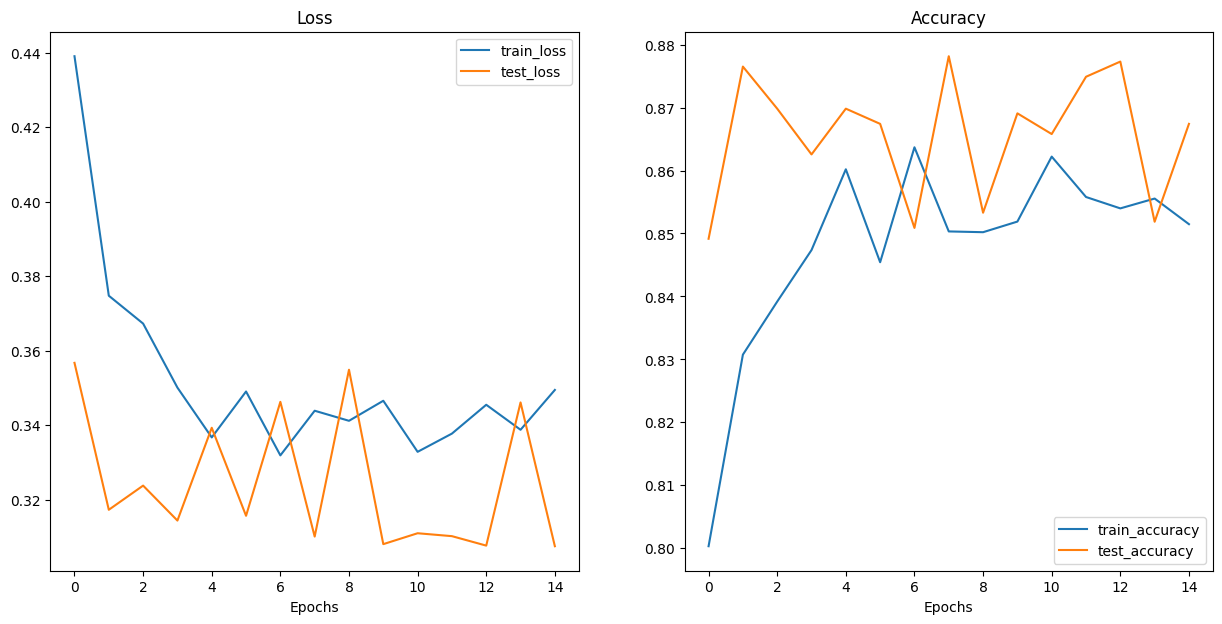

In [33]:
plot_loss_curves(results)

In [36]:
MODEL_PATH = Path("kaggle/working/model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet152_ai_vs_real_img_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(),
          f=MODEL_SAVE_PATH)

In [37]:
# import torchvision
# import torch
# from pathlib import Path
# import matplotlib as plt
# model = torchvision.models.resnet152(weights="IMAGENET1K_V2")
# model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
# model.load_state_dict(torch.load(f="/kaggle/input/resnet152_ai_vs_real_img_model/pytorch/model/1/resnet152_ai_vs_real_img_model.pth", map_location=torch.device("cpu")))
# device = "cpu"
# model = model.to(device)


In [38]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        label,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device,
                       ):
    
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    model.to(device)

    model.eval()
    with torch.inference_mode():
      
      transformed_image = image_transform(img).unsqueeze(dim=0)

      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.sigmoid(target_image_pred).squeeze()
    target_image_pred_label = torch.round(target_image_pred_probs).int()


    plt.figure()
    plt.imshow(img)
    if class_names[target_image_pred_label] == label:
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs:.3f} | Label: {label}", c="g")
    else:
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs:.3f} | Label: {label}", c="r")
    plt.axis(False);

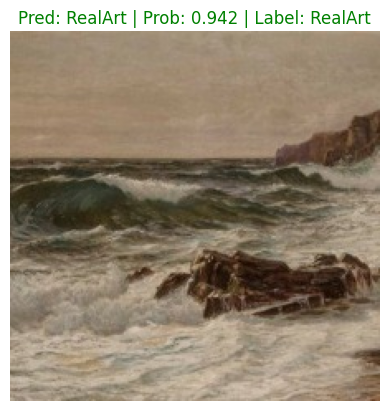

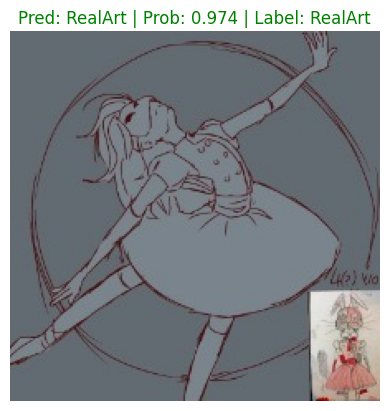

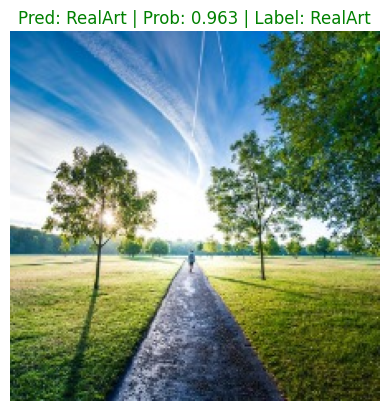

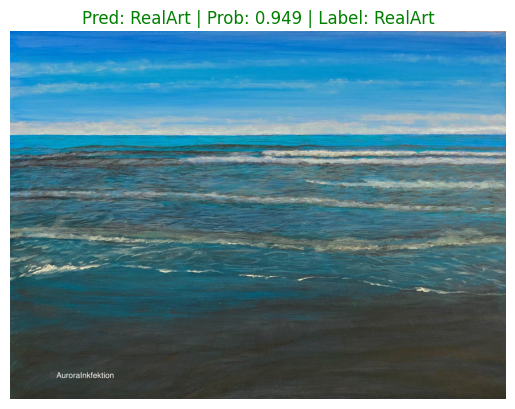

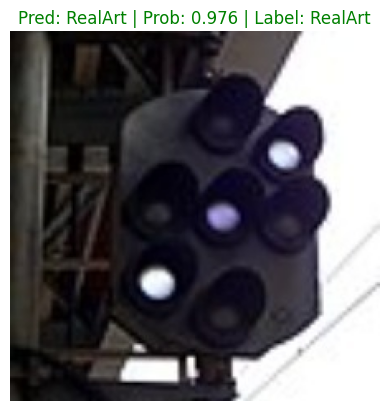

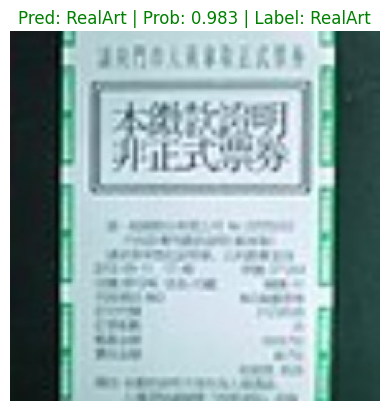

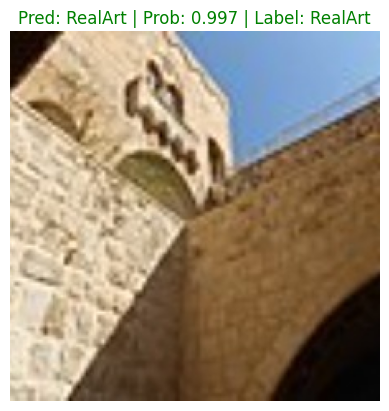

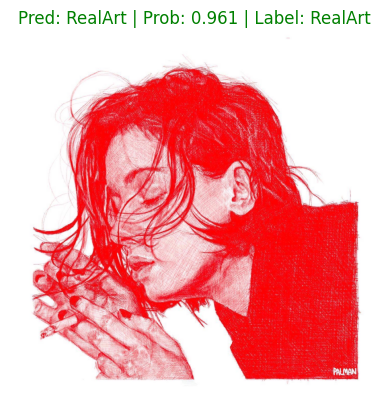

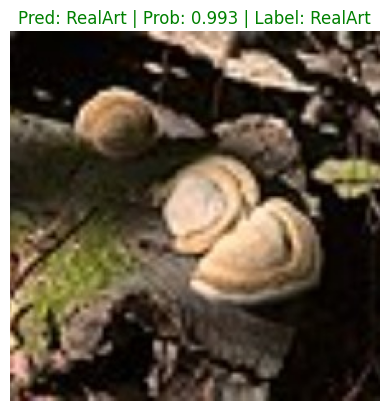

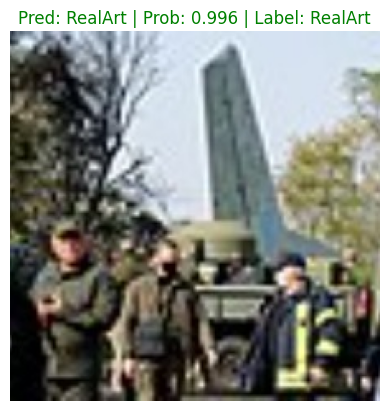

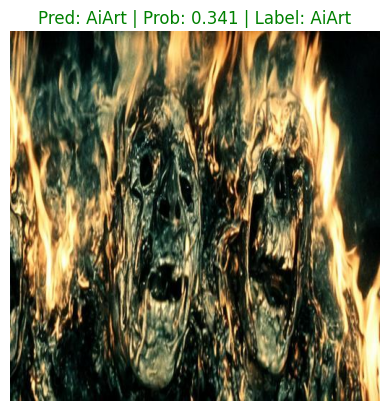

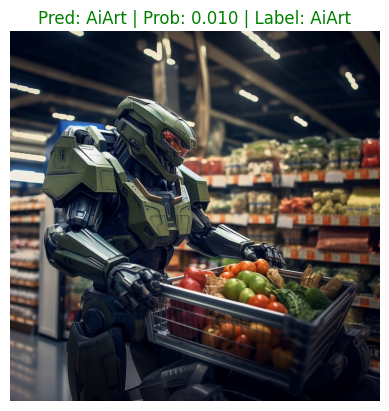

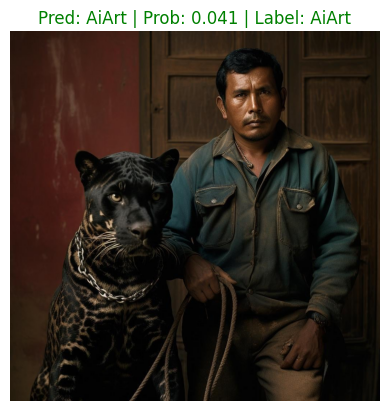

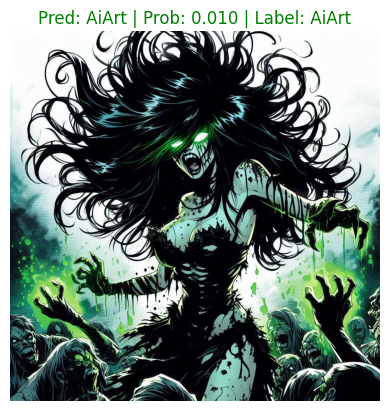

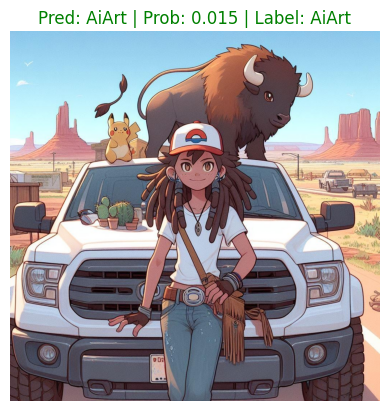

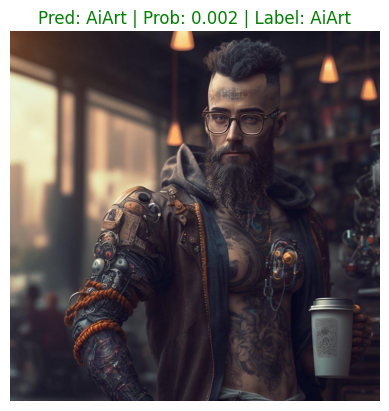

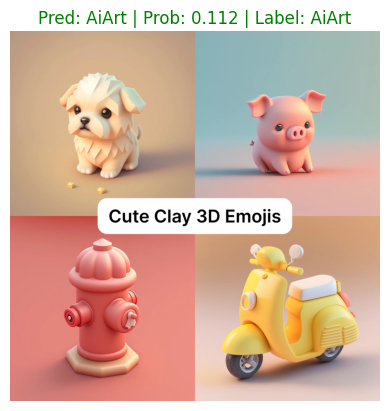

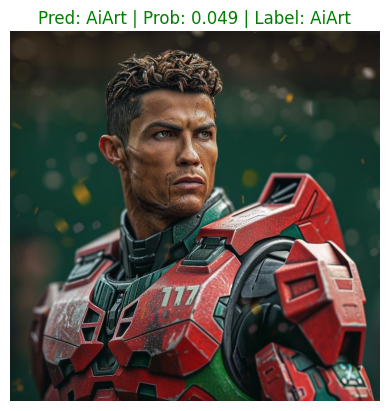

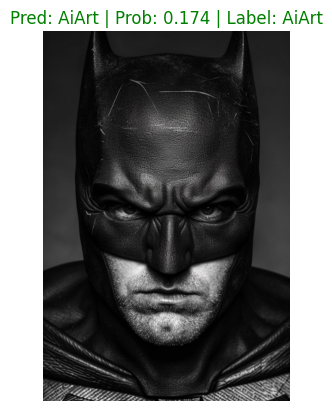

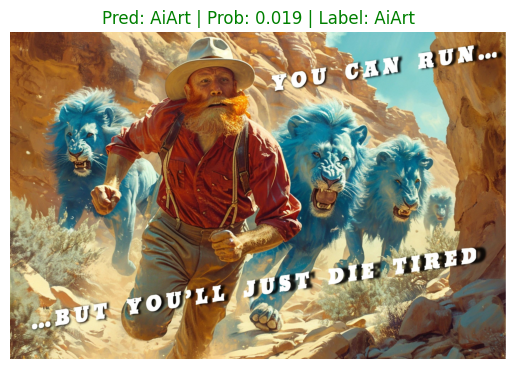

In [56]:
import random
num_images_to_plot = 10
test_real_list = list(Path("/Users/sahilpambhar/Downloads/archive (4)").glob("real/*")) 
test_real_sample = random.sample(population=test_real_list, 
                                       k=num_images_to_plot) 
test_ai_list = list(Path("/Users/sahilpambhar/Downloads/archive (4)/fakeV2").glob("fake-v2/*.jpg")) 
test_ai_sample = random.sample(population=test_ai_list, 
                                       k=num_images_to_plot) 


for image_path in test_real_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(),
                        image_size=(224, 224),
                       label="RealArt")
for image_path in test_ai_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(),
                        image_size=(224, 224),
                       label="AiArt")

In [40]:
test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn)
print(f"Accuracy of model on test data: {test_acc * 100 :.3f}%")

Accuracy of model on test data: 86.741%
